# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
import phik
from phik.report import plot_correlation_matrix
from phik import report
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split
import shap

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [30]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
1283,x-1917627k,Smart Coupe,economy,petrol,5.08,2013,43212,2020,36.79,electro_bug
1392,U19913900a,Kia Rio,economy,petrol,4.38,2012,21139,2018,34.20,break_bug
260,G13398649k,VW Polo,economy,petrol,4.20,2014,65872,2017,54.52,engine_ignition
1984,S-1674892M,Hyundai Solaris,economy,petrol,4.62,2014,65210,2016,25.84,electro_bug
2278,G-6618695l,Kia Rio,economy,petrol,3.94,2015,86367,2019,24.76,break_bug


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [31]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
406227,u95988277B,c66464279D,r1F,2020-02-29,7.98,22,193,65,106.782702,0,1441.042387,0,-27.886636,0.000
203249,t10928335r,O-2688441F,r1T,2020-01-10,4.04,14,177,44,73.000000,1,200.583891,0,16.271867,-4.673
137359,u73351119Q,J22595982W,S1h,2020-02-08,1.01,51,708,52,156.184973,0,2733.103963,0,-9.556035,11.139
271284,A12784688w,S50025102C,K1Z,2020-01-10,4.40,15841,174246,49,64.000000,2,790284.910834,0,4.012189,13.881
197445,R22592753Q,N87823081W,R1t,2020-03-09,0.63,984,10975,49,92.355463,3,1704.079011,0,6.588332,-0.000


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [32]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
7578,49,7.8,1998,8.0,c70997713L,0,2022-1-15
2078,40,6.7,1211,10.0,I18046674q,0,2019-1-2
318,26,8.0,2667,6.0,C16741106F,1,2017-6-18
8446,44,8.4,1180,5.0,D96161810j,0,2019-1-9
10061,25,9.3,1014,17.0,r19290494R,1,2020-11-7


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [33]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
98478,l34820395K,RB,2020-5-10 7:39,reparking,1.0,25
49265,m-1618295c,IT,2020-9-18 3:24,repair,5.0,22
104209,R17548053Q,RR,2019-6-12 21:39,reparking,1.0,28
61949,N18096525X,HV,2020-10-20 14:12,repair,5.5,11
54581,Q-2192864t,VL,2020-7-6 21:47,reparking,1.0,26


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

In [34]:
df_rides_info = rides_info.groupby("car_id", as_index=False).agg(
    # минимальный рейтинг за все поездки
    rating_min=("rating", "min"),
    # средний рейтинг за все поездки
    rating_mean=("rating", "mean"),
    # общее кол-во километров, которые машина проехала
    distance_sum=("distance", "sum"),
    # максимальная скорость
    speed_max_max=("speed_max", "max"),
    # общее кол-во поездок для каждой машины
    ride_id_count=("ride_id", "count"),

    # средний показатель датчиков состояния машины
    deviation_normal_min=("deviation_normal", "mean"),
    # оценка манеры вождения
    user_ride_quality_mean=("user_ride_quality", "mean"),
    # общая длительность поездок
    ride_duration_sum=("ride_duration", "sum")
)

In [35]:
df_driver_info = driver_info.groupby("user_id", as_index=False).agg(
    # минимальный рейтинг за все поездки
    user_rating_min=("user_rating", "min"),
    # средний рейтинг за все поездки
    user_rating_mean=("user_rating", "mean"),
    # общее кол-во инцидентов
    user_time_accident_sum=("user_time_accident", "sum")
)

In [36]:
df_fix_info = fix_info.groupby("car_id", as_index=False).agg(
    # общая длительность работ
    work_duration_min=("work_duration", "sum"),
    # общая степень износа
    destroy_degree_sum=("destroy_degree", "sum"),
    # средняя степень износа
    destroy_degree_mean=("destroy_degree", "mean")
)

In [52]:
df_final = car_train.copy()
df_final = pd.merge(df_final, rides_info, how='left', on='car_id')
df_final = pd.merge(df_final, driver_info, how='left', on='user_id')
df_final = pd.merge(df_final, fix_info, how='left', on='car_id')
df_final = pd.merge(df_final, df_rides_info, how='left', on='car_id')
df_final = pd.merge(df_final, df_driver_info, how='left', on='user_id')
df_final = pd.merge(df_final, df_fix_info, how='left', on='car_id')
df_final

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,ride_id_count,deviation_normal_min,user_ride_quality_mean,ride_duration_sum,user_rating_min,user_rating_mean,user_time_accident_sum,work_duration_min,destroy_degree_sum,destroy_degree_mean
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,174,-0.120391,-0.901190,284624,7.4,7.4,2.0,933,106.7,3.048571
1,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,174,-0.120391,-0.901190,284624,7.4,7.4,2.0,933,106.7,3.048571
2,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,174,-0.120391,-0.901190,284624,7.4,7.4,2.0,933,106.7,3.048571
3,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,174,-0.120391,-0.901190,284624,7.4,7.4,2.0,933,106.7,3.048571
4,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,174,-0.120391,-0.901190,284624,7.4,7.4,2.0,933,106.7,3.048571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13970455,z-1337463D,VW Polo,economy,petrol,3.94,2015,92312,2016,54.68,engine_check,...,174,21.628856,-12.320655,412727,7.7,7.7,0.0,825,109.5,3.220588
13970456,z-1337463D,VW Polo,economy,petrol,3.94,2015,92312,2016,54.68,engine_check,...,174,21.628856,-12.320655,412727,7.7,7.7,0.0,825,109.5,3.220588
13970457,z-1337463D,VW Polo,economy,petrol,3.94,2015,92312,2016,54.68,engine_check,...,174,21.628856,-12.320655,412727,7.7,7.7,0.0,825,109.5,3.220588
13970458,z-1337463D,VW Polo,economy,petrol,3.94,2015,92312,2016,54.68,engine_check,...,174,21.628856,-12.320655,412727,7.7,7.7,0.0,825,109.5,3.220588


## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [53]:
cols2drop = ['car_id', 'user_id', 'ride_id', 'worker_id', 'ride_id_count', 'model', 'ride_date', 'first_ride_date', 'fix_date']
df_final = df_final.drop(cols2drop, axis=1)

#### Линейная корреляция

In [68]:
df_lin_corr = df_final.copy()
cols2drop = ['car_type', 'fuel_type', 'work_type']
df_lin_corr = df_lin_corr.drop(cols2drop, axis=1)

df_lin_corr = df_lin_corr.drop('target_class', axis=1)

categorical_to_exclude = df_lin_corr.select_dtypes(include=['object']).columns.tolist()
df_linear_corr = df_lin_corr.drop(categorical_to_exclude, axis=1, errors = 'ignore')

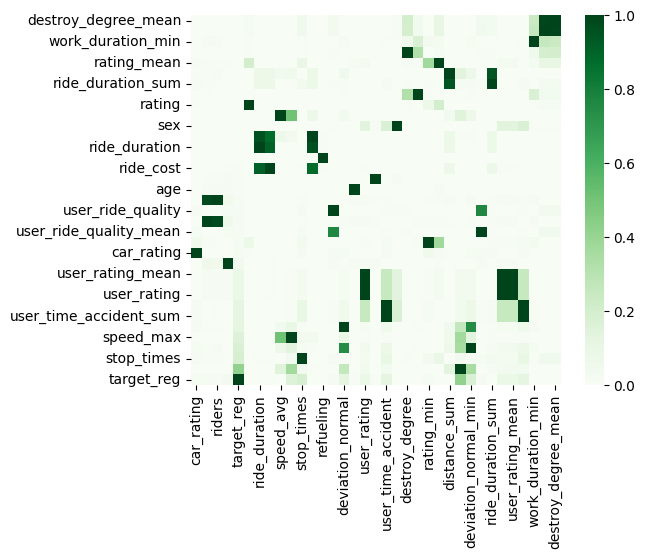

In [71]:
corrs = df_lin_corr.dropna().corr().round(3).sort_values('target_reg')
res = sns.heatmap(corrs,
            cmap = 'Greens',
            square=True,
            vmin = 0)

На данном графике мы можем видеть, что регрессионный таргет сильно коррелирует с колонкой
- speed_max_max (максимальная скорость)

Других корреляций с регрессионным таргетом не наблюдается, но т.к данный метод не подходит для категориальных признаков, это не удивительно.

#### Phik

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'rating', 'ride_duration', 'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance', 'refueling', 'user_ride_quality', 'deviation_normal', 'age', 'user_rating', 'user_rides', 'user_time_accident', 'sex', 'destroy_degree', 'work_duration', 'rating_min', 'rating_mean', 'distance_sum', 'speed_max_max', 'ride_id_count', 'deviation_normal_min', 'user_ride_quality_mean', 'ride_duration_sum', 'user_rating_min', 'user_rating_mean', 'user_time_accident_sum', 'work_duration_min', 'destroy_degree_sum', 'destroy_degree_mean']


c:\Users\savsp\AppData\Local\Programs\Python\Python312\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable ride_id_count for analysis 1. Dropping this column
  warnings.warn(


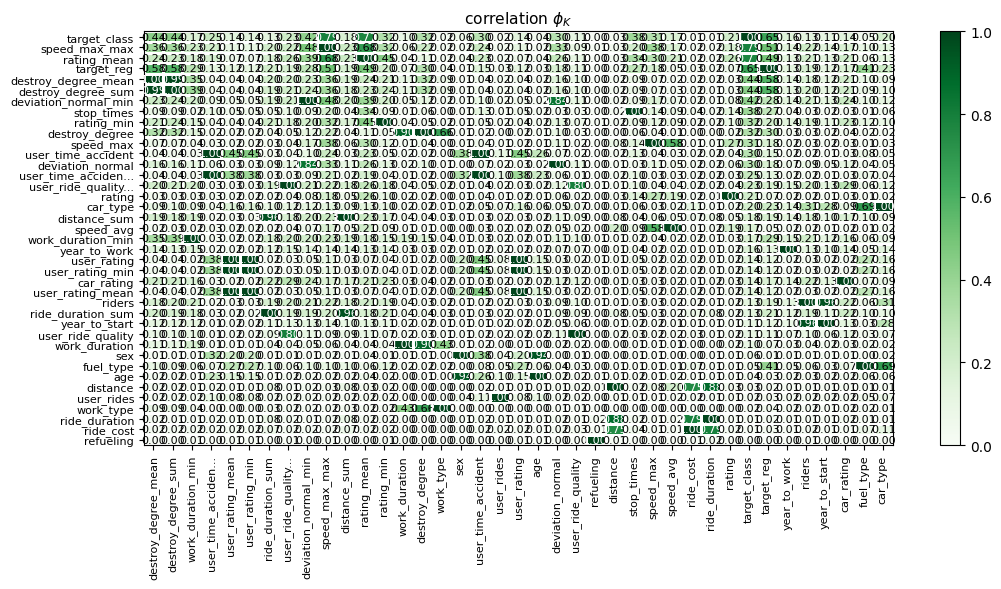

In [41]:
df_phik = df_final.copy()
phik_overview = df_phik.phik_matrix().round(2).sort_values('target_class')

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

In [72]:
significance_overview = df_phik.significance_matrix().fillna(0).round(1).sort_values('target_reg')

plot_correlation_matrix(significance_overview.values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=0, vmax=1, color_map="Greens",
                        title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'rating', 'ride_duration', 'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance', 'refueling', 'user_ride_quality', 'deviation_normal', 'age', 'user_rating', 'user_rides', 'user_time_accident', 'sex', 'destroy_degree', 'work_duration', 'rating_min', 'rating_mean', 'distance_sum', 'speed_max_max', 'ride_id_count', 'deviation_normal_min', 'user_ride_quality_mean', 'ride_duration_sum', 'user_rating_min', 'user_rating_mean', 'user_time_accident_sum', 'work_duration_min', 'destroy_degree_sum', 'destroy_degree_mean']


c:\Users\savsp\AppData\Local\Programs\Python\Python312\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable ride_id_count for analysis 1. Dropping this column
  warnings.warn(


На графиках выше видно, что регрессионный таргет коррелирует с колонками:
- destroy_degree_mean (степень износа машины)
- destroy_degree_sum (степень износа машины)
- user_time_accident (число инцидентов водителя)
- deviation_normal_min (показатель датчиков машины)
- speed_max_max (максимальная скорость)
- rating_mean (рейтинг, поставленный водителем)
- destroy_degree (степень износа машины)
- fuel_type (тип топлива машины)
- car_type (класс машины)

что выглядит как логичное заключение, т.к признаки выглядят достаточно сильными.

#### Permutation Importance

In [45]:
df_permute = df_final.copy()
drop_cols = ['car_id', 'ride_date', 'first_ride_date', 'fix_date', 'target_class']
cat_cols = ['car_type', 'fuel_type', 'work_type']

X = df_permute.drop(drop_cols, axis=1, errors = 'ignore')
y = df_permute['target_class'].fillna(0)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
model = CatBoostClassifier(random_state=42,
                           cat_features=cat_cols,
                           thread_count=-1)
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=100, plot=False, 
          early_stopping_rounds=100)

Learning rate set to 0.130105
0:	learn: 1.5426852	test: 1.5430525	best: 1.5430525 (0)	total: 33.5s	remaining: 9h 17m 28s
100:	learn: 0.0713709	test: 0.0715461	best: 0.0715461 (100)	total: 1h 40m 49s	remaining: 14h 57m 25s
200:	learn: 0.0202000	test: 0.0202580	best: 0.0202580 (200)	total: 2h 30m 58s	remaining: 10h 8s
300:	learn: 0.0070862	test: 0.0071077	best: 0.0071077 (300)	total: 3h 21m 25s	remaining: 7h 47m 45s
400:	learn: 0.0025702	test: 0.0025771	best: 0.0025771 (400)	total: 4h 11m 44s	remaining: 6h 16m 2s
500:	learn: 0.0010221	test: 0.0010257	best: 0.0010257 (500)	total: 5h 2m 11s	remaining: 5h 59s
600:	learn: 0.0004417	test: 0.0004428	best: 0.0004428 (600)	total: 5h 50m 58s	remaining: 3h 53m
700:	learn: 0.0002551	test: 0.0002557	best: 0.0002557 (700)	total: 6h 34m 55s	remaining: 2h 48m 27s
800:	learn: 0.0001658	test: 0.0001662	best: 0.0001662 (800)	total: 7h 17m 26s	remaining: 1h 48m 40s
900:	learn: 0.0001252	test: 0.0001255	best: 0.0001255 (900)	total: 7h 58m 34s	remaining: 52m

In [48]:
# Посмотрим на важность признаков катбуста
fi = model.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,rating_mean,19.098252
1,speed_max_max,15.993347
2,target_reg,14.220129
3,deviation_normal_min,6.101844
4,user_ride_quality_mean,5.759443
5,rating_min,4.406403
6,destroy_degree_mean,4.380828
7,work_duration_min,4.096876
8,destroy_degree_sum,3.988765
9,distance_sum,3.788095


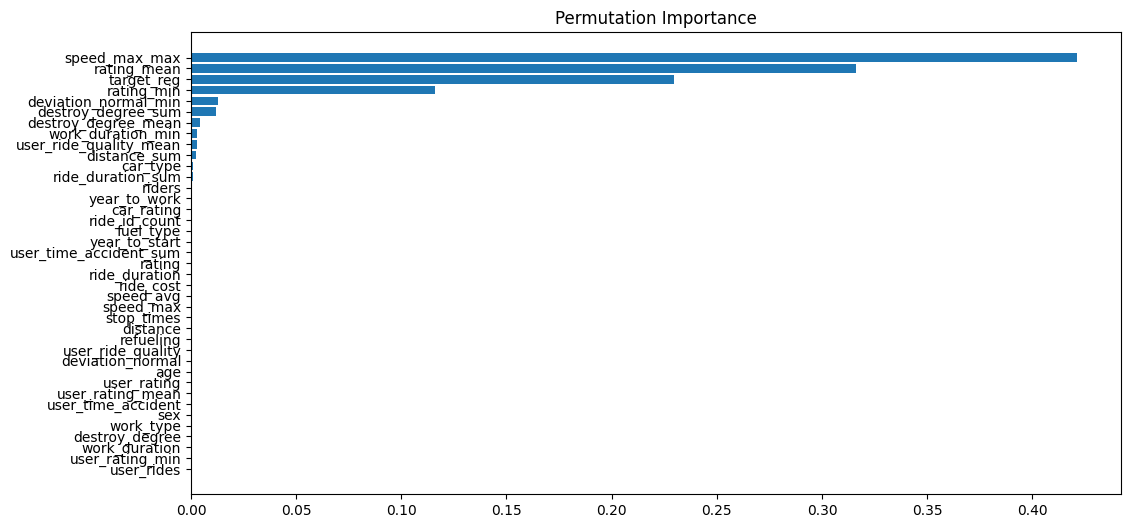

In [49]:
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

Здесь можно заметить, что значимость признаков выстраивается следующим образом:
- speed_max_max
- rating_min
- deviation_normal_min
- destroy_degree_sum
- destroy_degree_mean
- work_duration_min
- user_ride_quality_mean
- distance_sum
- car_type
- ride_duration_sum<br/>
...   ...   ...

Максимальная скорость, рейтинг, степень износа машины находятся в топе, что лишь подтверждает предыдущие результаты.
Можем присмотреться к данным результатам и продолжить анализ.

#### SHAP values

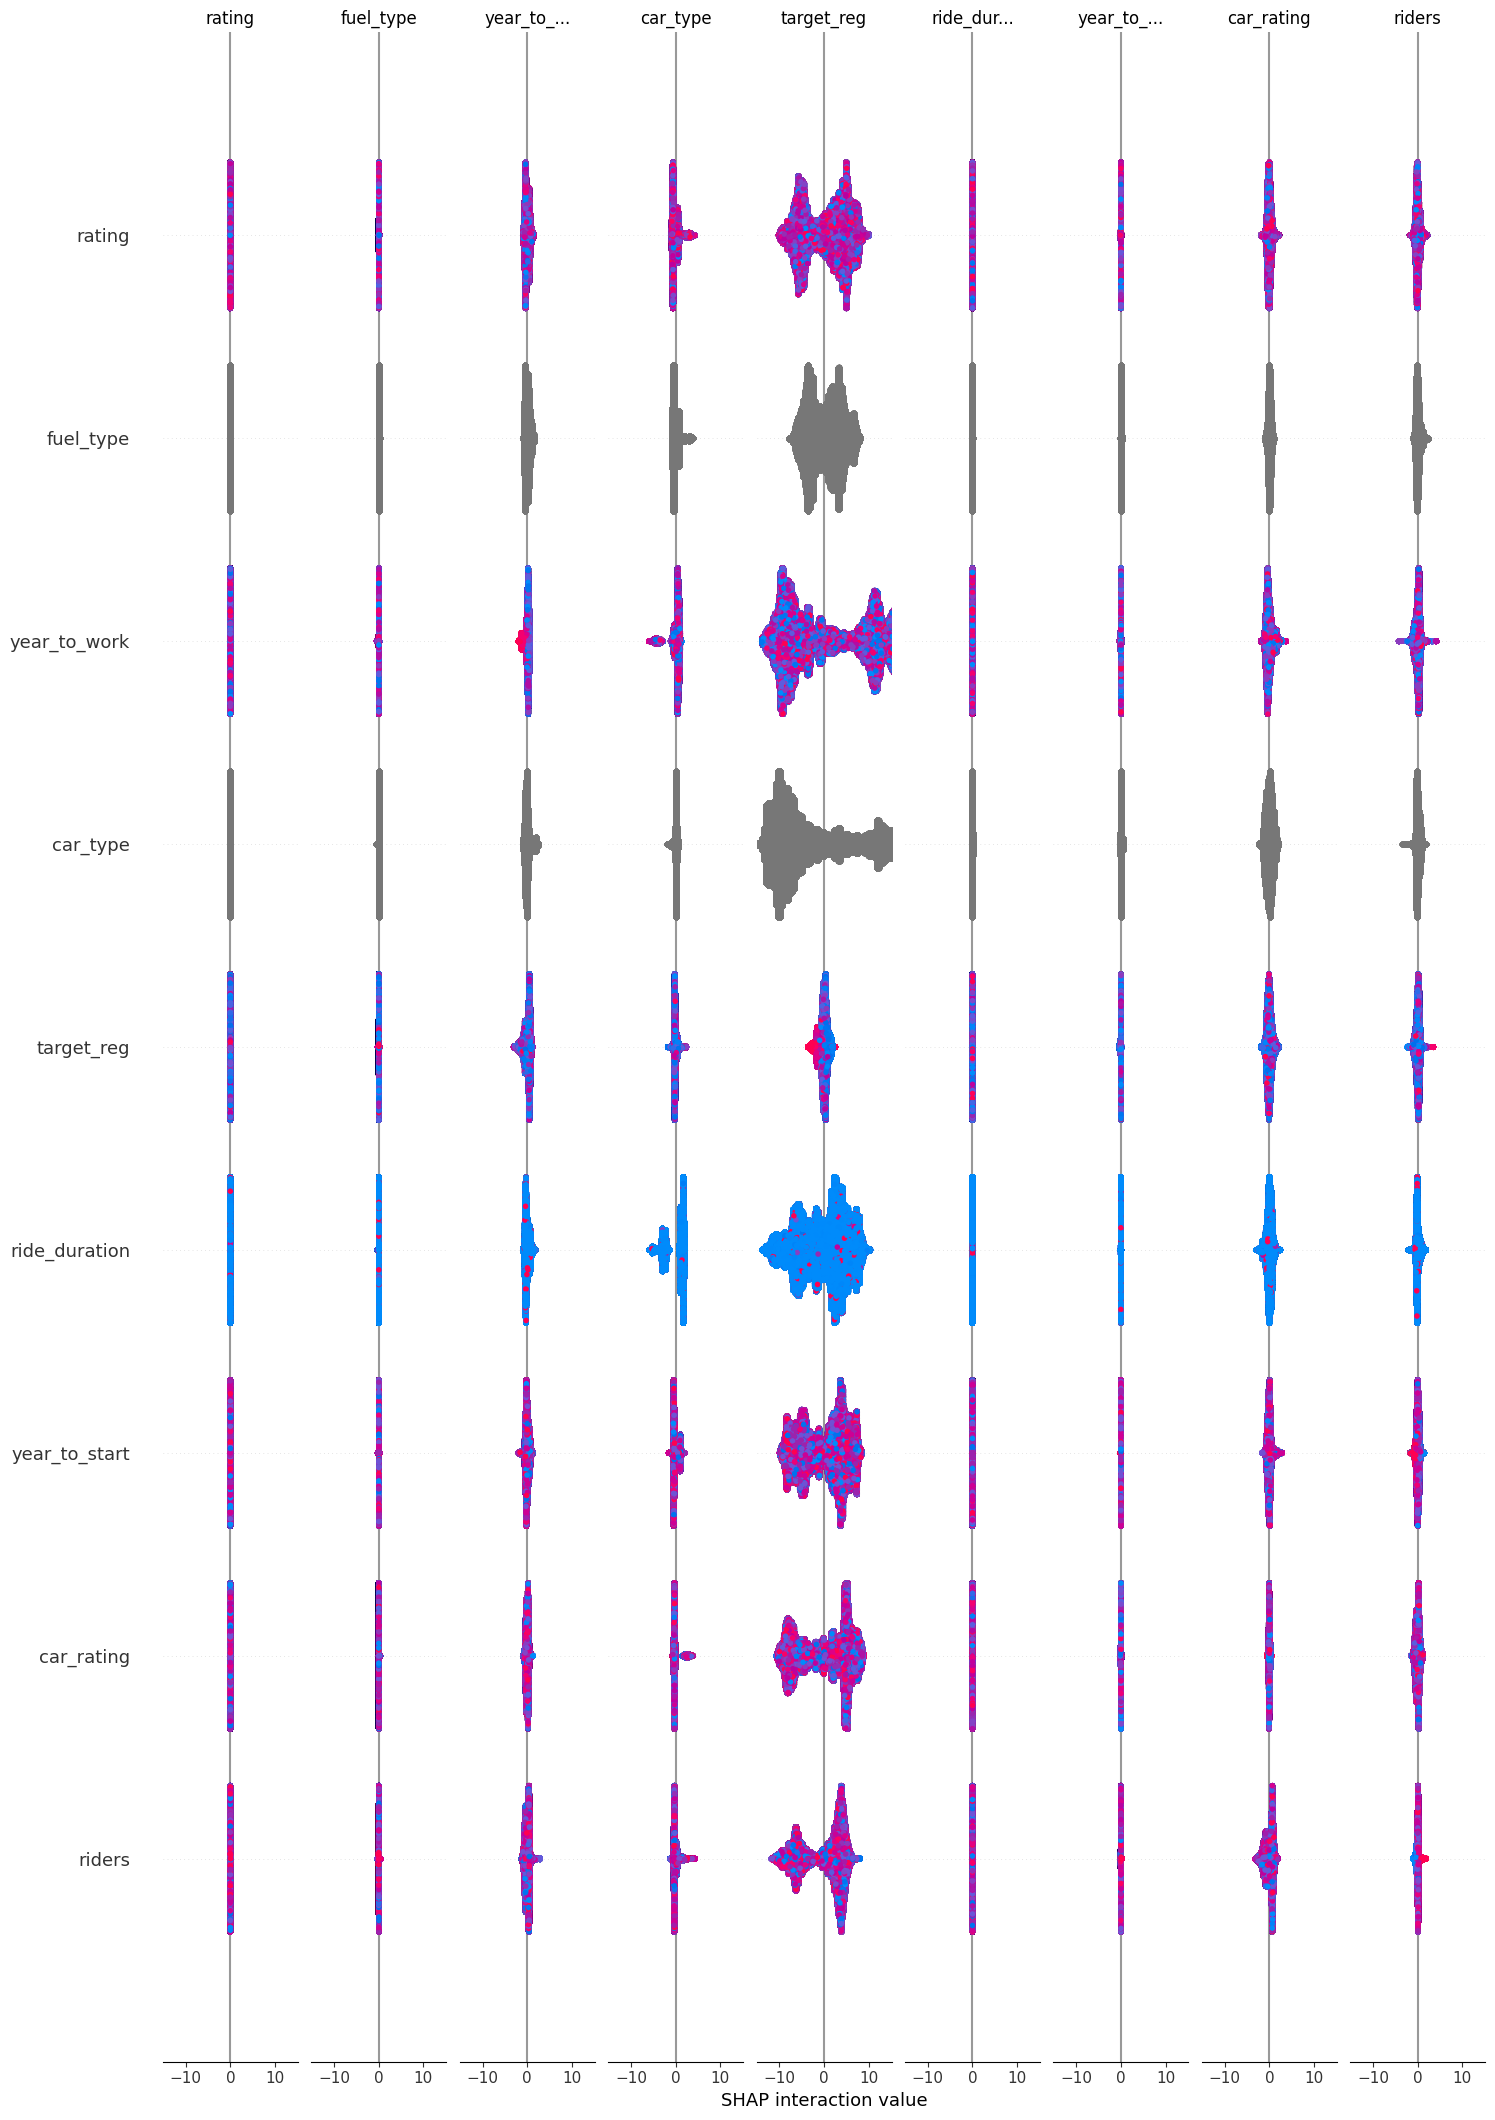

In [50]:
# Посмотрим на SHAP values
explainer = shap.TreeExplainer(model)

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_cols)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display = 25)

Результат данного графика выглядит несколько неожиданным. Такие признаки, как "класс машины" и "тип топлива", вероятно, не важны для предсказания класса и их можно попробовать откинуть.

На основании выполненного задания можно подвести итог и сделать следующие выводы.<br/>
Линейная корреляция работает быстро, не улавливает нелинейные зависимости и не подходит для категориальных признаков.<br/>
Phik корреляция улавливает зависимость между категориальными признаками, но работает достаточно долго.<br/>
Permutation importance подходит для отсеивания признаков, но нет гарантии, что низкий по важности признак не снизит точность модели.<br/>
SHAP values также неплохо себя показал и увидел еще несколько признаков, которые некоторые методы фильтрации не выявили.

На данном этапе существует ряд признаков, которые потенциально можно удалить, но этого пока не требуется по условию.

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
features2drop = [...] # то, что надо выбросить
targets = [...] # таргеты
cat_features = [...] # категориальные признаки

num_features = [...] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 1 [Ellipsis]
Числовые признаки: 1 [Ellipsis]
Целевые переменные [Ellipsis]


In [ ]:
# YOUR CODE HERE

# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

In [ ]:
# YOUR CODE HERE

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
0,P17494612l,Skoda Rapid,economy,petrol,4.80,2013,42269,2019
1,N-1530212S,Renault Sandero,standart,petrol,4.32,2015,90014,2016
2,B-1154399t,Smart ForTwo,economy,petrol,4.46,2015,82684,2017


In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.